In [1]:
import geopandas as gpd, pandas as pd, rasterio as rio, json,  numpy as np, matplotlib.pyplot as plt, math
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.enums import Resampling
from rasterio.transform import rowcol
from shapely.geometry import Polygon
from scipy.integrate import odeint
from shapely.geometry import Point
from rasterio.plot import show
from rasterio.mask import mask

In [2]:
# add the administrative borders paths
province_borders_path = "Limiti01012023/ProvCM01012023/ProvCM01012023_WGS84.shp"
region_borders_path = "Limiti01012023/Reg01012023/Reg01012023_WGS84.shp"

# load the administrative borders
region_borders = gpd.read_file(region_borders_path)
province_borders = gpd.read_file(province_borders_path)

#filter vector data for the area of interest
emilia = region_borders[region_borders['DEN_REG'] == 'Emilia-Romagna']

In [3]:
emilia_census_data = pd.read_csv('Census_data/2021_provisional/Dati_regionali_2021/R08_indicatori_2021_sezioni.csv', encoding='latin-1', sep=';')

In [4]:
gdf_census = gpd.read_file('Census_data/2011/R08_11_WGS84/R08_11_WGS84.shp')

In [5]:
# Esegui il join tra df e gdf sulla colonna comune
gdf = gdf_census.merge(emilia_census_data, on='SEZ2011', how='left')

In [6]:
# fill nan data to be readable
for i in gdf.columns:
    if gdf[i].dtype == int:
        gdf[i] = gdf[i].fillna(0).astype(int)

In [7]:
# Calcola la densità di popolazione per ogni poligono
# Calcola l'area in metri quadrati
gdf['area_m2'] = gdf.geometry.area

# Converti l'area in chilometri quadrati
gdf['area_km2'] = gdf['area_m2'] / 1e6

gdf['pop_density'] = gdf['P1'] / gdf['area_km2']

In [ ]:
#gdf.to_file('Census_data/join.shp')

## Rasterize the census data to raster

In [ ]:
# Sostituisci i valori NaN con 0 nella colonna 'pop_density'
gdf['pop_density'] = gdf['pop_density'].fillna(0)

# Apri il raster di riferimento per ottenere i dettagli sulla griglia
with rio.open("DEM/Emilia-Romagna1.tif") as src:
    bounds = src.bounds
    pixel_size_x, pixel_size_y = src.res  # Risoluzione in x e y
    width = src.width
    height = src.height
    transform = rio.transform.from_bounds(*bounds, width, height)

# Funzione per ottenere il valore da rasterizzare
def get_val(geom, val):
    return val

# Crea un array vuoto per il raster
raster = np.zeros((height, width), dtype=np.float32)

# Rasterizza per la densità della popolazione
rasterized_pop_density = rasterize(
    ((row.geometry, get_val(row.geometry, row['pop_density'])) for idx, row in gdf.iterrows()),
    out=raster,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='float32'
)

# Rasterizza per la maschera di "emilia"
rasterized_mask = rasterize(
    ((geom, 1) for geom in emilia['geometry']),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='float32'
)

# Applica la maschera al raster della densità della popolazione
masked_raster = np.where(rasterized_mask == 1, rasterized_pop_density, np.nan)

# Salva il raster con la maschera applicata
with rio.open(
    'Census_data/masked_pop_density.tif', 'w',
    driver='GTiff',
    height=masked_raster.shape[0],
    width=masked_raster.shape[1],
    count=1,
    dtype=masked_raster.dtype,
    crs=src.crs,
    transform=transform,
) as dst:
    dst.write(masked_raster, 1)

In [ ]:
def mask_raster_with_geodataframe(raster_path, gdf, output_path):
    # Carica il raster
    with rio.open(raster_path) as src:
        # Converti le geometrie del GeoDataFrame in formati accettati da rio
        geometries = [feature["geometry"] for _, feature in gdf.iterrows()]
        out_image, out_transform = mask(src, geometries, crop=True)

        # Salva il raster mascherato
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [ ]:
# Esempio di utilizzo
mask_raster_with_geodataframe('Census_data/masked_pop_density.tif', emilia,
                              'Census_data/masked_pop_density_mask.tif')

### Rasterize buildings

In [ ]:
%%time

buildings = gpd.read_file('Buildings_data/volumetria_edifici_uniti.shp')

In [ ]:
# Apri il raster di riferimento per ottenere i dettagli sulla griglia
with rio.open("DEM/Emilia-Romagna1.tif") as src:
    bounds = src.bounds
    pixel_size_x, pixel_size_y = src.res  # Risoluzione in x e y
    width = src.width
    height = src.height
    transform = src.transform

    # Crea un array vuoto per il raster degli edifici
    raster = np.zeros((height, width), dtype=np.float32)

    # Rasterizza gli edifici per l'altezza (H_UVL)
    shapes = ((geom, height) for geom, height in zip(buildings.geometry, buildings['H_UVL']))
    rasterized_buildings = rasterize(shapes, out=raster, transform=transform, fill=0, all_touched=True, dtype='float32')

In [ ]:
# Specifica il percorso e il nome del file TIFF di output
output_path = 'Buildings_data/buildings_raster.tif'

# Apri un nuovo file TIFF in modalità scrittura
with rio.open(output_path, 'w', driver='GTiff', height=height, width=width, count=1, dtype='float32', crs=src.crs, transform=transform) as dst:
    # Scrivi il raster modificato nel file TIFF
    dst.write(rasterized_buildings, 1)

## Sommo dem + edifici

In [ ]:
def sum_rasters(raster1_path, raster2_path, output_path):
    # Apri il primo raster
    with rio.open(raster1_path) as src1:
        raster1 = src1.read(1)

        # Sostituisci i valori nodata con 0
        nodata1 = src1.nodata
        raster1[raster1 == nodata1] = 0

        # Apri il secondo raster
        with rio.open(raster2_path) as src2:
            # Assicurati che i raster abbiano le stesse dimensioni
            raster2 = src2.read(
                1, 
                out_shape=(src1.height, src1.width),
                resampling=Resampling.nearest
            )

            # Sostituisci i valori nodata con 0 (se presente)
            nodata2 = src2.nodata
            if nodata2 is not None:
                raster2[raster2 == nodata2] = 0

            # Somma i raster
            result = raster1 + raster2

            # Salva il raster risultante
            profile = src1.profile
            with rio.open(output_path, 'w', **profile) as dst:
                dst.write(result, 1)

# Esempio di utilizzo
sum_rasters('DEM/Emilia-Romagna1.tif', 'Buildings_data/buildings_raster.tif', 'Buildings_data/DEM_plus_buildings_raster.tif')

In [ ]:
# Esempio di utilizzo
mask_raster_with_geodataframe('Buildings_data/DEM_plus_buildings_raster.tif', emilia, 'Buildings_data/DEM_plus_buildings_raster_mask.tif')

## Impact risk

### First trial

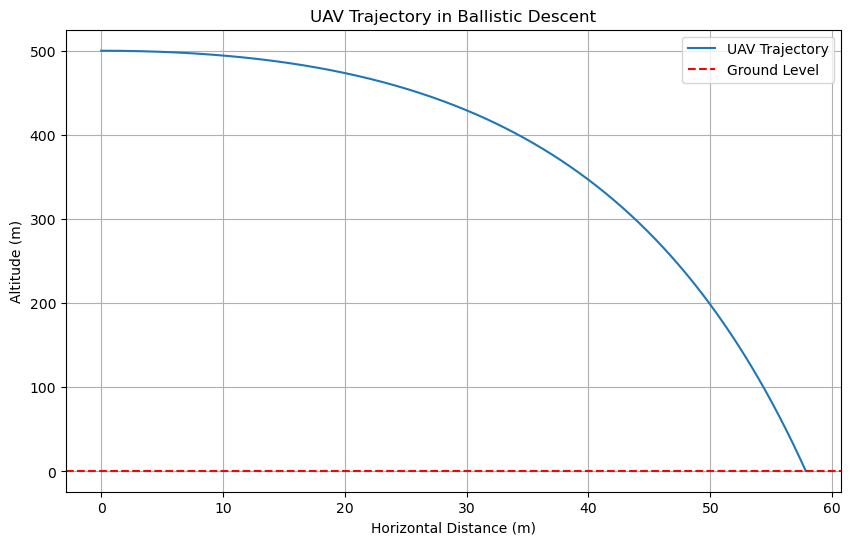

(8.64864864864865, 57.8891545124992, 88.21144112249702)

In [8]:
# Constants
m = 1.0  # Mass of the UAV (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
c = 0.1  # Drag coefficient
vxi = 10  # Initial horizontal velocity (m/s)
vyi = 0  # Initial vertical velocity (m/s)
initial_altitude = 500  # Starting altitude (meters)

# Function for the system of differential equations
def system(y, t, m, g, c, vxi):
    x, vx, vy = y
    dvx_dt = -c * vx / m
    dvy_dt = -g + c * vy / m
    return [vx, dvx_dt, dvy_dt]

# Initial conditions: x0, vx0, vy0
y0 = [0, vxi, vyi]

# Time points where we evaluate the solution
t = np.linspace(0, 15, 1000)  # Increased time range

# Solve the system of differential equations
sol = odeint(system, y0, t, args=(m, g, c, vxi))

# Extract the x and y positions and velocities
x = sol[:, 0]
vx = sol[:, 1]
vy = sol[:, 2]
y = initial_altitude + np.cumsum(vy) * (t[1] - t[0])  # Properly integrate vy over time

# Find the time and velocities of impact
impact_index = np.argmax(y < 0)
impact_time = t[impact_index]
impact_x = x[impact_index]
impact_vx = vx[impact_index]
impact_vy = vy[impact_index]

# Calculate the impact angle in degrees
impact_angle = np.arctan2(abs(impact_vy), impact_vx) * (180 / np.pi)

# Plotting the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x[:impact_index], y[:impact_index], label="UAV Trajectory")
plt.axhline(y=0, color='r', linestyle='--', label="Ground Level")
plt.title("UAV Trajectory in Ballistic Descent")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.grid(True)
plt.show()

impact_time, impact_x, impact_angle

### Second trial

In [9]:
def converti_km_h_in_m_s(velocita_km_h):
    return velocita_km_h / 3.6

In [10]:
velocita_km_h = 120

In [11]:
# Constants and initial conditions
m = 1.0  # Mass of the UAV (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
c = 0.1  # Drag coefficient
vxi = 10 #converti_km_h_in_m_s(velocita_km_h)  # Initial horizontal velocity (m/s)
altitude = 500  # Initial altitude of the drone (m)
dt = 0.01  # Time step for the simulation

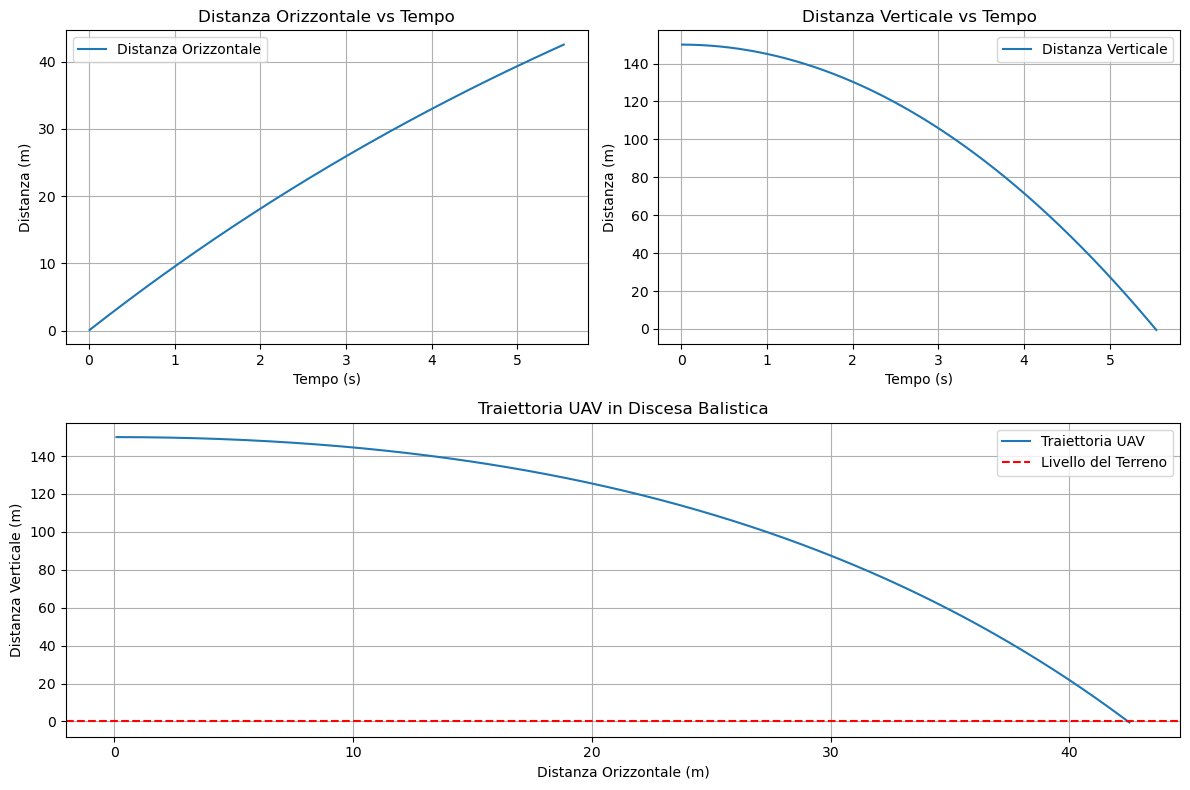

Tempo di Caduta: 5.539999999999926 secondi
Distanza Orizzontale Percorsa: 42.514073816694435 metri
Angolo d'Impatto: 83.96421133041045 gradi
Energia Cinetica all'Impatto: 1493.3308803077057 joule


In [14]:
# Funzioni per le velocità e la distanza
def vx(t):
    return vxi * np.exp(-c/m * t)

def y_adjusted(t):
    return altitude - 0.5 * g * t**2

# Re-inizializzazione dei dati della simulazione
time = 0
x_total, y_total_adjusted = 0, altitude
times_adjusted, x_positions_adjusted, y_positions_adjusted = [], [], []

while y_total_adjusted > 0:
    time += dt
    x_total += vx(time) * dt
    y_total_adjusted = y_adjusted(time)

    times_adjusted.append(time)
    x_positions_adjusted.append(x_total)
    y_positions_adjusted.append(y_total_adjusted)

# Calcolo del tempo di caduta
tempo_di_caduta = times_adjusted[-1]

# Calcolo della distanza orizzontale prima dell'impatto
distanza_orizzontale = x_positions_adjusted[-1]

# Calcolo dell'angolo d'impatto
vx_impact = vx(tempo_di_caduta)
vy_impact = g * tempo_di_caduta
angolo_d_impact = math.atan2(vy_impact, vx_impact)
angolo_d_impact_gradi = math.degrees(angolo_d_impact)

# Calcolo dell'energia cinetica all'impatto
velocita_totale_impact = math.sqrt(vx_impact**2 + vy_impact**2)
energia_cinetica_impact = 0.5 * m * velocita_totale_impact**2

# Plotting
plt.figure(figsize=(12, 8))

# Distanza Orizzontale nel Tempo
plt.subplot(2, 2, 1)
plt.plot(times_adjusted, x_positions_adjusted, label="Distanza Orizzontale")
plt.xlabel("Tempo (s)")
plt.ylabel("Distanza (m)")
plt.title("Distanza Orizzontale vs Tempo")
plt.grid(True)
plt.legend()

# Distanza Verticale nel Tempo
plt.subplot(2, 2, 2)
plt.plot(times_adjusted, y_positions_adjusted, label="Distanza Verticale")
plt.xlabel("Tempo (s)")
plt.ylabel("Distanza (m)")
plt.title("Distanza Verticale vs Tempo")
plt.grid(True)
plt.legend()

# Traiettoria UAV
plt.subplot(2, 1, 2)
plt.plot(x_positions_adjusted, y_positions_adjusted, label="Traiettoria UAV")
plt.axhline(y=0, color='r', linestyle='--', label="Livello del Terreno")
plt.xlabel("Distanza Orizzontale (m)")
plt.ylabel("Distanza Verticale (m)")
plt.title("Traiettoria UAV in Discesa Balistica")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Stampa dei risultati
print(f"Tempo di Caduta: {tempo_di_caduta} secondi")
print(f"Distanza Orizzontale Percorsa: {distanza_orizzontale} metri")
print(f"Angolo d'Impatto: {angolo_d_impact_gradi} gradi")
print(f"Energia Cinetica all'Impatto: {energia_cinetica_impact} joule")

## Raster ballistic trajectory 360°

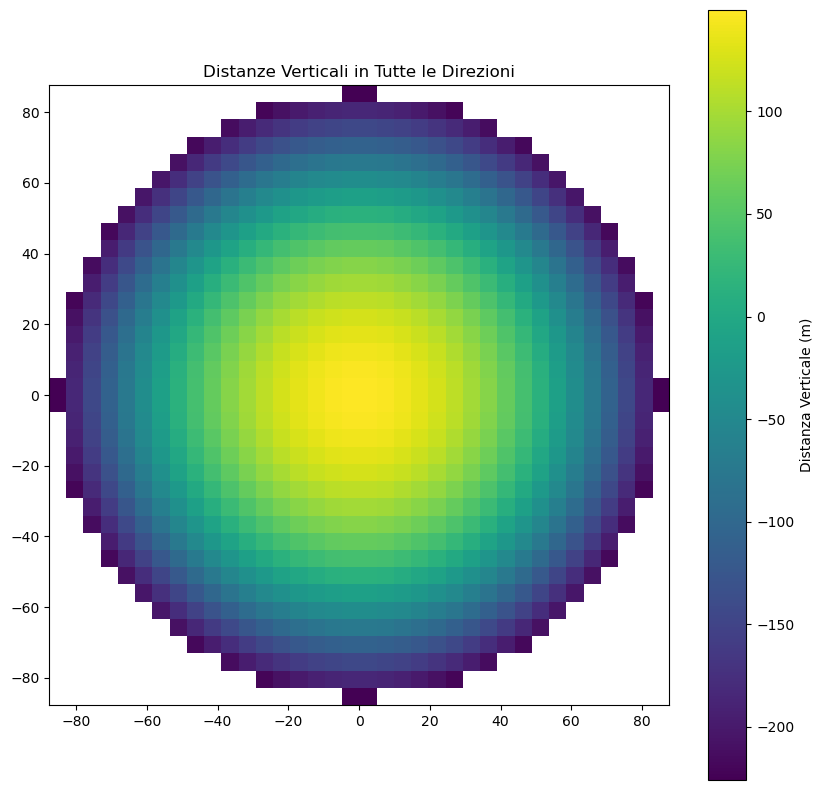

In [15]:
# Caricare il raster e ottenere la risoluzione spaziale
file_raster = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif'  # Sostituisci con il percorso del tuo file raster
with rio.open(file_raster) as src:
    risoluzione_spaziale = src.res[0]  # Assumendo che la risoluzione sia uguale in x e y
    profile = src.profile  # Ottieni il profilo del raster originale

# Constants and initial conditions for ballistic trajectory
m = 1.0  # Mass of the UAV (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
c = 0.1  # Drag coefficient
vxi = 10  # Initial horizontal velocity (m/s)
altitude = 150  # Initial altitude of the drone (m)
dt = 0.01  # Time step for the simulation
limite_distanza_verticale = -2000  # -2000 metri

# Funzioni per le velocità e la distanza
def vx(t):
    return vxi * np.exp(-c/m * t)

def y_adjusted(t):
    return altitude - 0.5 * g * t**2

# Calcolo della traiettoria balistica
time = 0
x_total, y_total_adjusted = 0, altitude
x_positions = []

while y_total_adjusted > limite_distanza_verticale:
    time += dt
    x_total += vx(time) * dt
    y_total_adjusted = y_adjusted(time)
    x_positions.append(x_total)

# Massima distanza orizzontale raggiunta
max_distanza_orizzontale = max(x_positions)

# Calcolo delle dimensioni della matrice basate sulla risoluzione spaziale
dimensione_matrice_orizzontale = int(np.ceil(max_distanza_orizzontale / risoluzione_spaziale))
dimensione_matrice = 2 * dimensione_matrice_orizzontale  # Per coprire tutte le direzioni

# Creazione della matrice
matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)

# Calcolo del centro della matrice
centro = dimensione_matrice // 2

# Riempimento della matrice con la distanza verticale calcolata
for i in range(dimensione_matrice):
    for j in range(dimensione_matrice):
        distanza_orizzontale = np.sqrt((i - centro + 0.5)**2 + (j - centro + 0.5)**2) * risoluzione_spaziale
        
        if distanza_orizzontale <= max_distanza_orizzontale:
            # Calcola la distanza verticale corrispondente
            t = distanza_orizzontale / vxi
            distanza_verticale = y_adjusted(t)
            matrice_distanze[i, j] = distanza_verticale


# Visualizzazione della matrice
plt.figure(figsize=(10, 10))
plt.imshow(matrice_distanze, origin='lower', extent=[-max_distanza_orizzontale, max_distanza_orizzontale, -max_distanza_orizzontale, max_distanza_orizzontale])
plt.colorbar(label='Distanza Verticale (m)')
plt.title('Distanze Verticali in Tutte le Direzioni')
plt.show()

## Raster ballistic trajectory 360° DEM adapted

### Get balistict trajectory from select point extracting the elevation

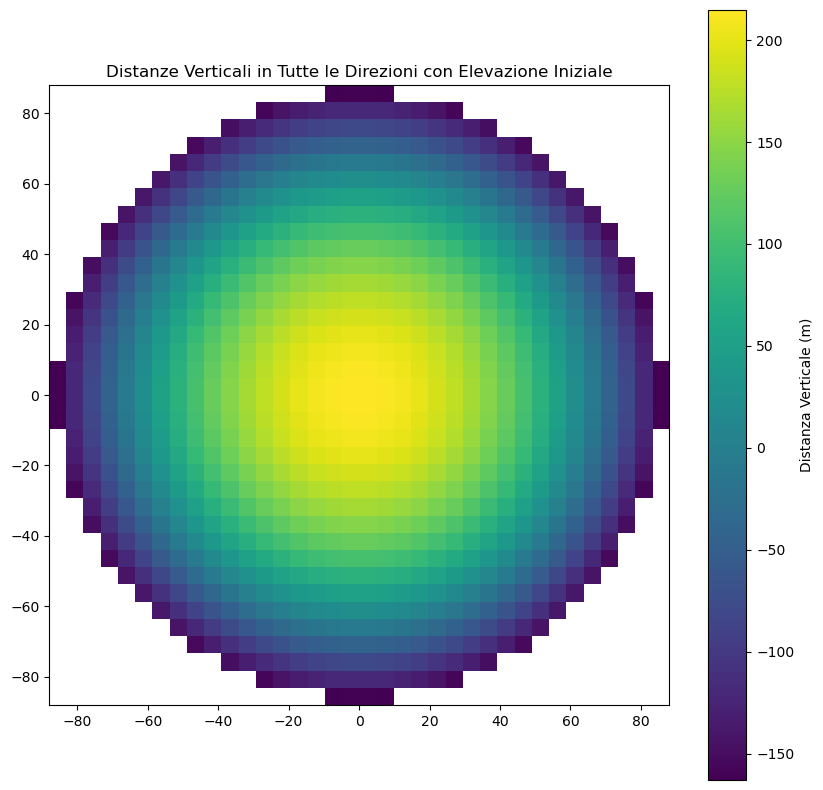

In [16]:
# Carica la DEM
file_raster = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif'
with rio.open(file_raster) as src:
    dem_data = src.read(1)  # Legge il primo layer della DEM
    nodata = src.nodata  # Valore di nodata
    res = src.res[0]  # Risoluzione spaziale

# Seleziona il pixel di partenza
start_x, start_y = dem_data.shape[1] // 2, dem_data.shape[0] // 2
elevazione_iniziale = dem_data[start_y, start_x] if dem_data[start_y, start_x] != nodata else 0

# Parametri per la traiettoria balistica
m = 1.0
g = 9.81
c = 0.1
vxi = 10
altitude_base = 150  # Altitudine di base del drone
dt = 0.01
limite_distanza_verticale = -2000  # Limite di distanza verticale

# Funzioni per le velocità e la distanza
def vx(t):
    return vxi * np.exp(-c/m * t)

def y_adjusted(t, elevazione_iniziale):
    return altitude_base + elevazione_iniziale - 0.5 * g * t**2

# Calcolo della traiettoria balistica
time = 0
x_total, y_total_adjusted = 0, altitude_base + elevazione_iniziale
x_positions = []

while y_total_adjusted > limite_distanza_verticale:
    time += dt
    x_total += vx(time) * dt
    y_total_adjusted = y_adjusted(time, elevazione_iniziale)
    x_positions.append(x_total)

# Massima distanza orizzontale raggiunta
max_distanza_orizzontale = max(x_positions)

# Calcolo delle dimensioni della matrice basate sulla risoluzione spaziale
dimensione_matrice_orizzontale = int(np.ceil(max_distanza_orizzontale / res))
dimensione_matrice = 2 * dimensione_matrice_orizzontale

# Creazione della matrice
matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)

# Riempimento della matrice con la distanza verticale calcolata
for i in range(dimensione_matrice):
    for j in range(dimensione_matrice):
        distanza_orizzontale = np.sqrt((i - dimensione_matrice // 2 + 0.5)**2 + (j - dimensione_matrice // 2 + 0.5)**2) * res

        if distanza_orizzontale <= max_distanza_orizzontale:
            t = distanza_orizzontale / vxi
            distanza_verticale = y_adjusted(t, elevazione_iniziale)
            matrice_distanze[i, j] = distanza_verticale

# Visualizzazione della matrice
plt.figure(figsize=(10, 10))
plt.imshow(matrice_distanze, origin='lower', extent=[-max_distanza_orizzontale, max_distanza_orizzontale, -max_distanza_orizzontale, max_distanza_orizzontale])
plt.colorbar(label='Distanza Verticale (m)')
plt.title('Distanze Verticali in Tutte le Direzioni con Elevazione Iniziale')
plt.show()

### Raster balistic trajectory - elevation

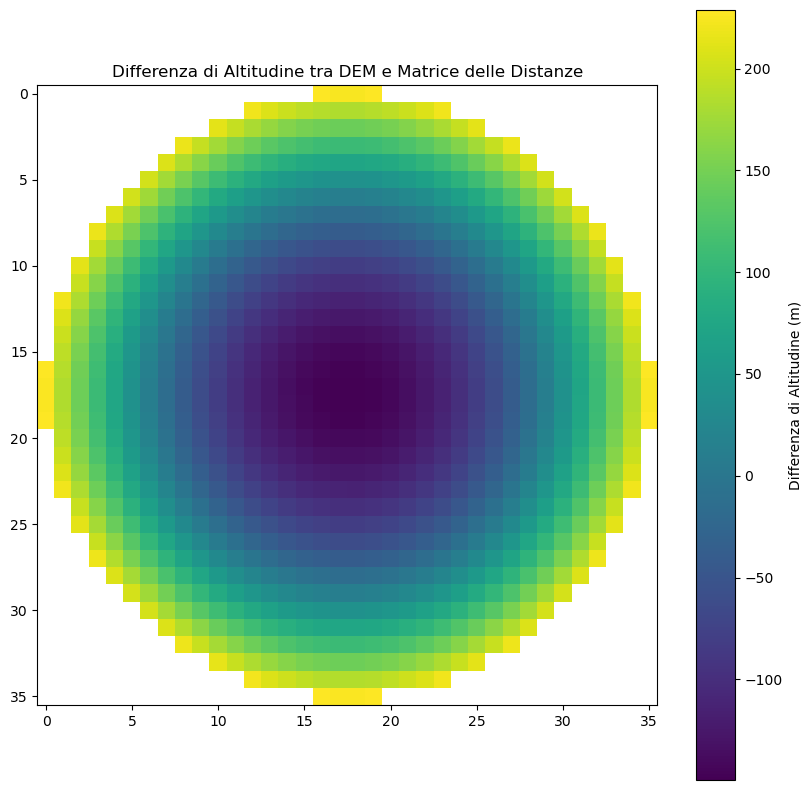

In [17]:
# Calcolo degli offset per allineare le matrici
offset_x = start_x - matrice_distanze.shape[1] // 2
offset_y = start_y - matrice_distanze.shape[0] // 2

# Creazione della matrice di sottrazione
sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)

# Sottrai la matrice_distanze dalla DEM solo dove sovrappongono
for i in range(matrice_distanze.shape[0]):
    for j in range(matrice_distanze.shape[1]):
        dem_x = j + offset_x
        dem_y = i + offset_y
        if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
            if not np.isnan(matrice_distanze[i, j]):
                valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]

# Visualizzazione della matrice risultante
plt.figure(figsize=(10, 10))
plt.imshow(sottrazione_matrice, cmap='viridis', vmin=np.nanmin(sottrazione_matrice), vmax=np.nanmax(sottrazione_matrice))
plt.colorbar(label='Differenza di Altitudine (m)')
plt.title('Differenza di Altitudine tra DEM e Matrice delle Distanze')
plt.show()

### Get values under or equal to 0 

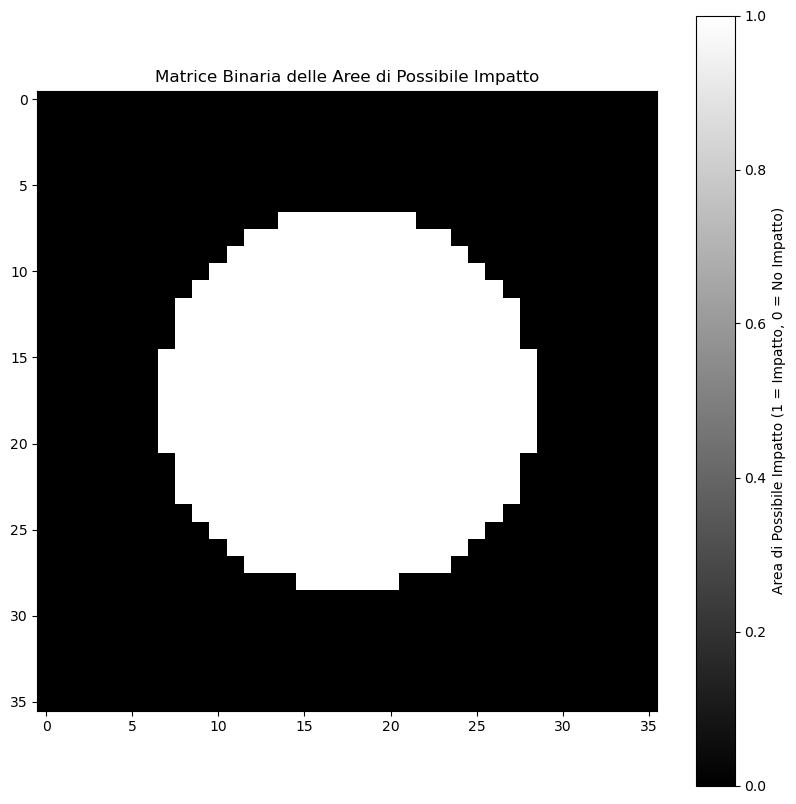

In [18]:
# Creazione della matrice binaria
matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)

# Visualizzazione della matrice binaria
plt.figure(figsize=(10, 10))
plt.imshow(matrice_binaria, cmap='gray')
plt.colorbar(label='Area di Possibile Impatto (1 = Impatto, 0 = No Impatto)')
plt.title('Matrice Binaria delle Aree di Possibile Impatto')
plt.show()

### Function to get a raster with areas with more impact

In [19]:
def calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale):
    def y_adjusted(t):
        return altitude_base - 0.5 * g * t ** 2

    def vx(t):
        return vxi * np.exp(-c / m * t)

    time = 0
    y_position = altitude_base
    distanza_orizzontale_percorsa = 0

    while y_position > limite_distanza_verticale:
        # Calcola la velocità orizzontale al tempo corrente
        velocita_orizzontale_attuale = vx(time)

        # Aggiorna dt in base alla velocità orizzontale attuale
        dt = res / velocita_orizzontale_attuale
        time += dt
        y_position = y_adjusted(time)
        distanza_orizzontale_percorsa += velocita_orizzontale_attuale * dt

    dimensione_matrice_orizzontale = int(np.ceil(distanza_orizzontale_percorsa / res))
    dimensione_matrice = 2 * dimensione_matrice_orizzontale
    matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)

    centro = dimensione_matrice // 2
    for i in range(dimensione_matrice):
        for j in range(dimensione_matrice):
            distanza_orizzontale = np.sqrt((i - centro) ** 2 + (j - centro) ** 2) * res
            if distanza_orizzontale <= distanza_orizzontale_percorsa:
                t = distanza_orizzontale / vxi  # Questo potrebbe essere aggiornato per riflettere la decelerazione
                altitudine = y_adjusted(t)
                matrice_distanze[i, j] = altitudine

    return matrice_distanze

def calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, start_x, start_y):
    offset_x = start_x - matrice_distanze.shape[1] // 2
    offset_y = start_y - matrice_distanze.shape[0] // 2
    sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)
    for i in range(matrice_distanze.shape[0]):
        for j in range(matrice_distanze.shape[1]):
            dem_x = j + offset_x
            dem_y = i + offset_y
            if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                if not np.isnan(matrice_distanze[i, j]):
                    valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                    sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]
    matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)
    return sottrazione_matrice, matrice_binaria

def salva_come_raster(matrice, nome_file_raster, start_x, start_y, transform, crs):
    # Calcola la metà delle dimensioni della matrice
    metà_larghezza = matrice.shape[1] / 2
    metà_altezza = matrice.shape[0] / 2

    # Sposta il punto d'origine verso il basso di una quantità pari all'altezza della matrice
    new_origin_x = transform[2] + (start_x - metà_larghezza) * transform[0]
    new_origin_y = transform[5] + (start_y + metà_altezza) * transform[4] - matrice.shape[0] * transform[4]

    # Crea un nuovo profilo per il file raster
    new_profile = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': matrice.shape[1],
        'height': matrice.shape[0],
        'count': 1,
        'crs': crs,
        'transform': from_origin(new_origin_x, new_origin_y, transform[0], -transform[4])
    }

    # Salva la matrice come file raster
    with rio.open(nome_file_raster, 'w', **new_profile) as dst:
        dst.write(matrice.astype(rio.float32), 1)

### Other functions

In [21]:
def bresenham_line(x0, y0, x1, y1):
    """Genera i punti lungo una linea retta da (x0, y0) a (x1, y1) usando l'algoritmo di Bresenham."""
    dx = x1 - x0
    dy = y1 - y0
    x, y = x0, y0

    ix = 1 if dx > 0 else -1
    iy = 1 if dy > 0 else -1
    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += iy
                err += dx
            x += ix
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += ix
                err += dy
            y += iy

    yield x1, y1

def aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y):
    altezza, larghezza = matrice_binaria.shape

    for y in range(altezza):
        for x in range(larghezza):
            visibile = True
            for punto_x, punto_y in bresenham_line(centro_x, centro_y, x, y):
                if 0 <= punto_y < altezza and 0 <= punto_x < larghezza:
                    if matrice_binaria[punto_y, punto_x] == 0:
                        visibile = False
                        break
                else:
                    break

            if not visibile:
                matrice_binaria[y, x] = 0

    return matrice_binaria

def calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, centro_x, centro_y):
    offset_x = centro_x - matrice_distanze.shape[1] // 2
    offset_y = centro_y - matrice_distanze.shape[0] // 2
    sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)

    for i in range(matrice_distanze.shape[0]):
        for j in range(matrice_distanze.shape[1]):
            dem_x = j + offset_x
            dem_y = i + offset_y
            if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                if not np.isnan(matrice_distanze[i, j]):
                    valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                    sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]

    matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)

    # Aggiorna la matrice binaria utilizzando le coordinate di start come centro
    matrice_binaria_aggiornata = aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y)

    return sottrazione_matrice, matrice_binaria, matrice_binaria_aggiornata

In [22]:
def coordinate_geografiche_a_raster(transform, latitudine_desiderata, longitudine_desiderata):
    start_y, start_x = rowcol(transform, latitudine_desiderata, longitudine_desiderata)
    return start_y, start_x

In [23]:
# Esempio di utilizzo delle funzioni
file_raster = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif'

with rio.open(file_raster) as src:
    dem_data = src.read(1)
    nodata = src.nodata
    res = src.res[0]
    crs = src.crs
    transform = src.transform
    #start_x, start_y = dem_data.shape[1] // 3, dem_data.shape[0] // 2
    
    latitudine_desiderata = 604993.6
    longitudine_desiderata = 4962068.8
    start_y, start_x = coordinate_geografiche_a_raster(transform, latitudine_desiderata, longitudine_desiderata)
    
    # Parametri per la traiettoria balistica
    m = 1.0
    g = 9.81
    c = 0.1
    vxi = 10
    altitude_base = 400
    dt = 1
    limite_distanza_verticale = -1000

    # Calcola la matrice di distanze
    matrice_distanze = calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale)

    # Calcola la sottrazione e crea la matrice binaria
    sottrazione_matrice, matrice_binaria, matrice_binaria_aggiornata = calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, start_x, start_y)

    # Salva le matrici come raster
    nome_file_raster_sottrazione = 'DEM/sottrazione_align.tif'
    salva_come_raster(sottrazione_matrice, nome_file_raster_sottrazione, start_x, start_y, transform, crs)

    nome_file_raster_distanza = 'DEM/matrice_distanza.tif'
    salva_come_raster(matrice_distanze, nome_file_raster_distanza, start_x, start_y, transform, crs)

    nome_file_raster_binario = 'DEM/matrice_binaria.tif'
    salva_come_raster(matrice_binaria, nome_file_raster_binario, start_x, start_y, transform, crs)
    
    nome_file_raster_binario_aggiornato = 'DEM/matrice_binaria_aggiornata.tif'
    salva_come_raster(matrice_binaria_aggiornata, nome_file_raster_binario_aggiornato, start_x, start_y, transform, crs)

CPLE_AppDefinedError: Deleting DEM/sottrazione_align.tif failed: Permission denied

In [ ]:
# Carica la DEM
file_raster = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif'
with rio.open(file_raster) as src:
    dem_data = src.read(1)  # Legge il primo layer della DEM
    transform = src.transform  # Ottieni il transform per la conversione delle coordinate

    # Converti le coordinate del pixel in coordinate geografiche
    center_lon, center_lat = rio.transform.xy(transform, start_y, start_x, offset='center')

    # Crea un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=[Point(center_lon, center_lat)], crs=src.crs)

    # Salva il GeoDataFrame come file SHP
    gdf.to_file('DEM/center_point.shp')

In [ ]:
# Definisci i percorsi ai file delle matrici binarie e dello shapefile
path_matrice_binaria = 'DEM/matrice_binaria.tif'
path_matrice_binaria_aggiornata = 'DEM/matrice_binaria_aggiornata.tif'
path_shapefile = 'DEM/center_point.shp'

# Carica lo shapefile utilizzando geopandas
gdf = gpd.read_file(path_shapefile)

# Crea una figura con due subplot affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Carica e visualizza la prima matrice binaria nel primo subplot
with rio.open(path_matrice_binaria) as src1:
    # Se necessario, trasforma lo shapefile nello stesso CRS del raster
    # Questo è importante se il CRS dello shapefile è diverso da quello del raster
    gdf = gdf.to_crs(src1.crs)

    # Visualizza la prima matrice binaria nel primo subplot
    show(src1, ax=ax1, cmap='gray')

    # Disegna i punti (o altre geometrie) dello shapefile sul primo subplot
    gdf.plot(ax=ax1, marker='o', color='red', markersize=10)

# Carica e visualizza la seconda matrice binaria nel secondo subplot
with rio.open(path_matrice_binaria_aggiornata) as src2:
    # Se necessario, trasforma lo shapefile nello stesso CRS del raster
    # Questo è importante se il CRS dello shapefile è diverso da quello del raster
    gdf = gdf.to_crs(src2.crs)

    # Visualizza la seconda matrice binaria nel secondo subplot sovrapponendola alla prima
    show(src2, ax=ax2, cmap='gray', alpha=0.5)  # Usa alpha per rendere la sovrapposizione trasparente

# Mostra il plot con i due subplot affiancati
plt.show()

## Loop without multiprocessing

In [ ]:
%%time

# Parametri per la traiettoria balistica
m = 1.0
g = 9.81
c = 0.1
vxi = 12
altitude_base = 400
limite_distanza_verticale = -1000

# Carica la DEM
file_raster = 'DEM/Emilia-Romagna1.tif'
with rio.open(file_raster) as src:
    dem_data = src.read(1)
    nodata = src.nodata
    res = src.res[0]
    crs = src.crs
    transform = src.transform

    # Inizializza una matrice di conteggio delle dimensioni della DEM
    conteggio_impatti = np.zeros_like(dem_data, dtype=int)

    # Calcola la matrice di traiettoria una volta
    matrice_distanze = calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale)

    # Numero totale di pixel
    total_pixels = dem_data.shape[0] * dem_data.shape[1]
    print(f"Inizio elaborazione di {total_pixels} pixel.")

    # Loop sui pixel della DEM
    for y in range(dem_data.shape[0]):
        for x in range(dem_data.shape[1]):
            # Calcola la matrice binaria per il pixel corrente
            sottrazione_matrice, _, matrice_binaria = calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, x, y)

            # Aggiorna la matrice di conteggio
            for i in range(matrice_binaria.shape[0]):
                for j in range(matrice_binaria.shape[1]):
                    # Calcola le coordinate corrispondenti nella DEM
                    dem_x = x + j - matrice_binaria.shape[1] // 2
                    dem_y = y + i - matrice_binaria.shape[0] // 2
                    if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                        conteggio_impatti[dem_y, dem_x] += matrice_binaria[i, j]

            # Stampa l'avanzamento ogni 10000 pixel processati
            current_pixel = y * dem_data.shape[1] + x
            if current_pixel % 10000 == 0:
                print(f"Elaborati {current_pixel} su {total_pixels} pixel.")

    # Salva la matrice di conteggio come raster
    output_raster = 'DEM/conteggio_impatti.tif'
    salva_come_raster(conteggio_impatti, output_raster, dem_data.shape[1] // 2, dem_data.shape[0] // 2, transform, crs)

    print("Elaborazione completata.")

## Loop with multiprocessing

In [ ]:
%%time

import rasterio as rio, os
from rasterio import windows
import numpy as np
import multiprocessing

def suddividi_raster(file_raster_originale, num_partizioni_per_lato, output_folder):
    with rio.open(file_raster_originale) as src:
        larghezza, altezza = src.width // num_partizioni_per_lato, src.height // num_partizioni_per_lato
        for i in range(num_partizioni_per_lato):
            for j in range(num_partizioni_per_lato):
                window = windows.Window(col_off=i*larghezza, row_off=j*altezza, width=larghezza, height=altezza)
                transform = src.window_transform(window)
                output_raster = os.path.join(output_folder, f"partizione_{i}_{j}.tif")
                with rio.open(output_raster, 'w', driver='GTiff', height=altezza, width=larghezza,
                              count=1, dtype=src.dtypes[0], crs=src.crs, transform=transform) as dst:
                    data = src.read(1, window=window)
                    dst.write(data, 1)
                print(f"Partizione {output_raster} creata.")

def calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale):
    print("Inizio: calcola_traiettoria_e_matrice")

    def y_adjusted(t):
        return altitude_base - 0.5 * g * t ** 2

    def vx(t):
        return vxi * np.exp(-c / m * t)

    time = 0
    y_position = altitude_base
    distanza_orizzontale_percorsa = 0

    while y_position > limite_distanza_verticale:
        # Calcola la velocità orizzontale al tempo corrente
        velocita_orizzontale_attuale = vx(time)

        # Aggiorna dt in base alla velocità orizzontale attuale
        dt = res / velocita_orizzontale_attuale
        time += dt
        y_position = y_adjusted(time)
        distanza_orizzontale_percorsa += velocita_orizzontale_attuale * dt

    dimensione_matrice_orizzontale = int(np.ceil(distanza_orizzontale_percorsa / res))
    dimensione_matrice = 2 * dimensione_matrice_orizzontale
    matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)

    centro = dimensione_matrice // 2
    for i in range(dimensione_matrice):
        for j in range(dimensione_matrice):
            distanza_orizzontale = np.sqrt((i - centro) ** 2 + (j - centro) ** 2) * res
            if distanza_orizzontale <= distanza_orizzontale_percorsa:
                t = distanza_orizzontale / vxi  # Questo potrebbe essere aggiornato per riflettere la decelerazione
                altitudine = y_adjusted(t)
                matrice_distanze[i, j] = altitudine

    return matrice_distanze

def bresenham_line(x0, y0, x1, y1):
    print("Inizio: bresenham_line")
    
    """Genera i punti lungo una linea retta da (x0, y0) a (x1, y1) usando l'algoritmo di Bresenham."""
    dx = x1 - x0
    dy = y1 - y0
    x, y = x0, y0

    ix = 1 if dx > 0 else -1
    iy = 1 if dy > 0 else -1
    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += iy
                err += dx
            x += ix
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += ix
                err += dy
            y += iy

    yield x1, y1

def aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y):
    print("Inizio: aggiorna_visibilita_bresenham")
    altezza, larghezza = matrice_binaria.shape

    for y in range(altezza):
        for x in range(larghezza):
            visibile = True
            for punto_x, punto_y in bresenham_line(centro_x, centro_y, x, y):
                if 0 <= punto_y < altezza and 0 <= punto_x < larghezza:
                    if matrice_binaria[punto_y, punto_x] == 0:
                        visibile = False
                        break
                else:
                    break

            if not visibile:
                matrice_binaria[y, x] = 0

    return matrice_binaria

def calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, centro_x, centro_y):
    print("Inizio: calcola_sottrazione_e_matrice_binaria")
    offset_x = centro_x - matrice_distanze.shape[1] // 2
    offset_y = centro_y - matrice_distanze.shape[0] // 2
    sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)

    for i in range(matrice_distanze.shape[0]):
        for j in range(matrice_distanze.shape[1]):
            dem_x = j + offset_x
            dem_y = i + offset_y
            if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                if not np.isnan(matrice_distanze[i, j]):
                    valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                    sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]

    matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)

    # Aggiorna la matrice binaria utilizzando le coordinate di start come centro
    matrice_binaria_aggiornata = aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y)

    return sottrazione_matrice, matrice_binaria, matrice_binaria_aggiornata

def salva_come_raster(dati, output_raster, transform, crs):
    print("Inizio: salva_come_raster")
    with rio.open(output_raster, 'w', driver='GTiff', height=dati.shape[0],
                  width=dati.shape[1], count=1, dtype=dati.dtype,
                  crs=crs, transform=transform) as dst:
        dst.write(dati, 1)

def elabora_dem_partizionata(file_raster, output_raster, m, g, c, vxi, altitude_base, limite_distanza_verticale):
    print("Inizio: elabora_dem_partizionata")
    with rio.open(file_raster) as src:
        dem_data = src.read(1)
        nodata = src.nodata
        res = src.res[0]
        crs = src.crs
        transform = src.transform

        conteggio_impatti = np.zeros_like(dem_data, dtype=int)
        matrice_distanze = calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale)

        total_pixels = dem_data.shape[0] * dem_data.shape[1]
        pixels_processed = 0

        for y in range(dem_data.shape[0]):
            for x in range(dem_data.shape[1]):
                _, _, matrice_binaria = calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, x, y)

                for i in range(matrice_binaria.shape[0]):
                    for j in range(matrice_binaria.shape[1]):
                        dem_x = x + j - matrice_binaria.shape[1] // 2
                        dem_y = y + i - matrice_binaria.shape[0] // 2
                        if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                            conteggio_impatti[dem_y, dem_x] += matrice_binaria[i, j]

                pixels_processed += 1
                if pixels_processed % 10000 == 0:
                    print(f"Elaborazione: {pixels_processed} su {total_pixels} pixel completata.")

        salva_come_raster(conteggio_impatti, output_raster, transform, crs)
        print(f"Elaborazione completata per il file {file_raster}.")


def processa_partizione(args):
    print("Inizio: processa_partizione")
    try:
        return elabora_dem_partizionata(*args)
    except Exception as e:
        print(f"Errore in processa_partizione: {e}")
        raise

def genera_nomi_partizioni(num_partizioni, output_folder):
    print("Inizio: genera_nomi_partizioni")
    partizioni = []
    for i in range(num_partizioni):
        for j in range(num_partizioni):
            file_raster = f"{output_folder}/partizione_{i}_{j}.tif"
            output_raster = f"conteggio_impatti_partizione_{i}_{j}.tif"
            partizioni.append((file_raster, output_raster))
    return partizioni

if __name__ == "__main__":
    m, g, c, vxi, altitude_base, limite_distanza_verticale = 1.0, 9.81, 0.1, 12, 400, -1000
    num_partizioni_per_lato = 5  # Imposta il numero di partizioni per lato per una griglia 5x5
    file_raster_originale = 'DEM/Emilia-Romagna1.tif'  # Percorso del file raster originale
    output_folder = 'DEM/partizioni'  # Cartella di destinazione per le partizioni
    
    # Crea la directory di output se non esiste
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Suddividi il raster originale
    suddividi_raster(file_raster_originale, num_partizioni_per_lato, output_folder)

    # Prepara le partizioni per l'elaborazione parallela
    partizioni = genera_nomi_partizioni(num_partizioni_per_lato, output_folder)

    # Esegui l'elaborazione in parallelo
    with multiprocessing.Pool() as pool:
        task_args = [(partizione[0], partizione[1], m, g, c, vxi, altitude_base, limite_distanza_verticale) for partizione in partizioni]
        try:
            # Il metodo 'map' aspetta che tutti i task siano completati
            pool.map(processa_partizione, task_args)
            print("Elaborazione completata con successo")
        except Exception as e:
            print(f"Si sono verificati degli errori nell'elaborazione: {e}")
        finally:
            pool.close()
            pool.join()

Partizione DEM/partizioni\partizione_0_0.tif creata.
Partizione DEM/partizioni\partizione_0_1.tif creata.
Partizione DEM/partizioni\partizione_0_2.tif creata.
Partizione DEM/partizioni\partizione_0_3.tif creata.
Partizione DEM/partizioni\partizione_0_4.tif creata.
Partizione DEM/partizioni\partizione_1_0.tif creata.
Partizione DEM/partizioni\partizione_1_1.tif creata.
Partizione DEM/partizioni\partizione_1_2.tif creata.
Partizione DEM/partizioni\partizione_1_3.tif creata.
Partizione DEM/partizioni\partizione_1_4.tif creata.
Partizione DEM/partizioni\partizione_2_0.tif creata.
Partizione DEM/partizioni\partizione_2_1.tif creata.
Partizione DEM/partizioni\partizione_2_2.tif creata.
Partizione DEM/partizioni\partizione_2_3.tif creata.
Partizione DEM/partizioni\partizione_2_4.tif creata.
Partizione DEM/partizioni\partizione_3_0.tif creata.
Partizione DEM/partizioni\partizione_3_1.tif creata.
Partizione DEM/partizioni\partizione_3_2.tif creata.
Partizione DEM/partizioni\partizione_3_3.tif c

# Complicate code (stop here)

## Code without function

In [ ]:
# Constants and initial conditions
m = 1.0  # Mass of the UAV (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
c = 0.1  # Drag coefficient
vxi = 10  # Initial horizontal velocity (m/s)
relative_altitude = 150  # Relative altitude of the drone (m)
dt = 0.01  # Time step for the simulation
movement_angle = 45  # Movement angle in degrees, 0 is eastward, 90 is northward

# Load the DEM and read its data
dem_file = 'DEM/Emilia-Romagna1.tif'  # Path to the uploaded DEM file
with rio.open(dem_file) as dem:
    # Get dimensions of the raster
    width, height = dem.width, dem.height

    # Calculate the coordinates of the central pixel
    central_x, central_y = width // 2, height // 2

    # Read the elevation at the center
    start_elevation = dem.read(1)[central_y, central_x]

    # Store the entire DEM data in dem_data
    dem_data = dem.read(1)

    # Obtain the resolution of the DEM
    dem_resolution = dem.transform[0]  # Pixel width in meters

# Calculate initial absolute altitude (z-coordinate)
absolute_altitude = relative_altitude + start_elevation

# Convert movement angle to radians for calculation
angle_rad = np.radians(movement_angle)

# Functions for velocities and distance
def vx(t):
    return vxi * np.exp(-c/m * t)

def z_adjusted(t, start_altitude):
    return start_altitude - 0.5 * g * t**2

# Initialize simulation data with the starting position and initial values
time = 0
x_pixel_index, y_pixel_index = central_x, central_y  # Starting at the central pixel
times_adjusted = [time]
x_positions_meters = [central_x * dem_resolution]  # Convert starting pixel to meters
y_positions_meters = [central_y * dem_resolution]  # Convert starting pixel to meters
z_positions = [absolute_altitude]
terrain_elevations = [dem_data[central_y, central_x]]
horizontal_distances = [0]

# Rest of the simulation loop
while True:
    time += dt
    # Calcola lo spostamento orizzontale totale in metri
    total_horizontal_displacement = vx(time) * time

    # Calcola le componenti x e y dello spostamento in base all'angolo
    x_displacement_meters = total_horizontal_displacement * np.cos(angle_rad)
    y_displacement_meters = total_horizontal_displacement * np.sin(angle_rad)

    # Calcola la posizione corrente in metri e convertila in indici dei pixel
    x_position_meters = x_displacement_meters + (central_x * dem_resolution)
    y_position_meters = y_displacement_meters + (central_y * dem_resolution)
    x_pixel_index = int(x_position_meters / dem_resolution)
    y_pixel_index = int(y_position_meters / dem_resolution)

    # Assicurati che gli indici siano entro i limiti
    x_pixel_index = max(0, min(x_pixel_index, width - 1))
    y_pixel_index = max(0, min(y_pixel_index, height - 1))

    # Calcola la distanza orizzontale dalla posizione iniziale
    horizontal_distance = np.sqrt((x_position_meters - x_positions_meters[0])**2 + (y_position_meters - y_positions_meters[0])**2)
    horizontal_distances.append(horizontal_distance)

    # Get terrain elevation
    terrain_elevation = dem_data[y_pixel_index, x_pixel_index]
    terrain_elevations.append(terrain_elevation)

    # Calculate the drone's altitude (z-coordinate)
    z_position = z_adjusted(time, absolute_altitude)
    z_positions.append(z_position)

    # Append data to lists
    times_adjusted.append(time)
    x_positions_meters.append(x_position_meters)
    y_positions_meters.append(y_position_meters)

    # Check if the drone's altitude is zero or negative (end of flight)
    if z_position <= terrain_elevation:
        print("Drone has completed its flight.")
        break

# Example output for verification
for i in range(0, len(times_adjusted)):
    print(f"Time: {times_adjusted[i]}s, Horizontal Distance: {horizontal_distances[i]}m, Vertical Distance: {z_positions[i]}m, Terrain elevation: {terrain_elevations[i]}m")

## Code with function

In [ ]:
def pixel_to_coords(x, y, transform):
    # Converti le coordinate dei pixel in coordinate geografiche
    coords = rio.transform.xy(transform, y, x, offset='center')  # Restituisce (longitudine, latitudine)
    return coords

def simulate_uav_flight(dem, start_x, start_y, m, g, c, vxi, relative_altitude, dt, movement_angle):
    # Leggi i dati DEM e ottieni le dimensioni
    dem_data = dem.read(1)
    width, height = dem_data.shape
    dem_resolution = dem.transform[0]
    
    # Calcola l'elevazione di partenza e l'altitudine assoluta iniziale
    start_elevation = dem_data[start_y, start_x]
    absolute_altitude = relative_altitude + start_elevation
    angle_rad = np.radians(movement_angle)

    # Funzioni per calcolare la velocità e l'altitudine
    def vx(t):
        return vxi * np.exp(-c/m * t)

    def z_adjusted(t, start_altitude):
        return start_altitude - 0.5 * g * t**2

    # Inizializza i dati della simulazione
    time = 0
    total_horizontal_displacement = 0
    times_adjusted = [time]
    x_positions_meters = [start_x * dem_resolution]
    y_positions_meters = [start_y * dem_resolution]
    z_positions = [absolute_altitude]
    terrain_elevations = [start_elevation]
    horizontal_distances = [0]
    
    # Ciclo di simulazione
    while True:
        time += dt
        horizontal_velocity = vx(time)
        x_displacement_meters = horizontal_velocity * np.cos(angle_rad) * dt
        y_displacement_meters = horizontal_velocity * np.sin(angle_rad) * dt

        total_horizontal_displacement += np.sqrt(x_displacement_meters**2 + y_displacement_meters**2)
        horizontal_distance = total_horizontal_displacement

        x_position_meters = x_positions_meters[-1] + x_displacement_meters
        y_position_meters = y_positions_meters[-1] + y_displacement_meters

        x_pixel_index = int(x_position_meters / dem_resolution)
        y_pixel_index = int(y_position_meters / dem_resolution)
        x_pixel_index = max(0, min(x_pixel_index, width - 1))
        y_pixel_index = max(0, min(y_pixel_index, height - 1))

        terrain_elevation = dem_data[y_pixel_index, x_pixel_index]
        z_position = z_adjusted(time, absolute_altitude)

        if z_position <= terrain_elevation:
            geographic_coords = pixel_to_coords(x_pixel_index, y_pixel_index, dem.transform)
            break

        # Aggiorna le liste dei dati
        times_adjusted.append(time)
        horizontal_distances.append(horizontal_distance)
        x_positions_meters.append(x_position_meters)
        y_positions_meters.append(y_position_meters)
        z_positions.append(z_position)
        terrain_elevations.append(terrain_elevation)

    return times_adjusted, horizontal_distances, z_positions, terrain_elevations, geographic_coords

In [ ]:
# Utilizzo della funzione
dem_file = 'DEM/Emilia-Romagna1.tif'
with rio.open(dem_file) as dem:
    start_x, start_y = dem.width // 2, dem.height // 2
    
    m = 1.0
    g = 9.81
    c = 0.1
    vxi = 10
    relative_altitude = 500
    dt = 0.01
    movement_angle = 45
    
    times_adjusted, horizontal_distances, z_positions, terrain_elevations, geographic_coords = simulate_uav_flight(dem, start_x, start_y, m, g, c, vxi, relative_altitude, dt, movement_angle)

In [ ]:
# Output di esempio per la verifica
for i in range(0, len(times_adjusted)):
    print(f"Time: {times_adjusted[i]}s, Horizontal Distance: {horizontal_distances[i]}m, Vertical Distance: {z_positions[i]}m, Terrain elevation: {terrain_elevations[i]}m")

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

# Distanza Orizzontale nel Tempo
plt.subplot(2, 2, 1)
plt.plot(times_adjusted, horizontal_distances, label="Distanza Orizzontale")
plt.xlabel("Tempo (s)")
plt.ylabel("Distanza (m)")
plt.title("Distanza Orizzontale vs Tempo")
plt.grid(True)
plt.legend()

# Altezza del Drone sopra il Livello del Mare
plt.subplot(2, 2, 2)
plt.plot(times_adjusted, z_positions, label="Altezza sopra il Livello del Mare")
plt.xlabel("Tempo (s)")
plt.ylabel("Altezza (m)")
plt.title("Altezza del Drone sopra il Livello del Mare")
plt.grid(True)
plt.legend()

# Traiettoria UAV con Linea del Terreno
plt.subplot(2, 1, 2)
plt.plot(horizontal_distances, z_positions, label="Traiettoria UAV")
plt.plot(horizontal_distances, terrain_elevations, label="Linea del Terreno", color='brown', linestyle='--')
plt.xlabel("Distanza Orizzontale (m)")
plt.ylabel("Altezza (m) sopra il Livello del Mare")
plt.title("Traiettoria UAV in Discesa Balistica")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Carica la DEM una volta e utilizzala per tutte le simulazioni
dem_file_path = 'DEM/Emilia-Romagna1.tif'
with rio.open(dem_file_path) as dem:
    start_x, start_y = dem.width // 2, dem.height // 2
    m = 1.0
    g = 9.81
    c = 0.1
    vxi = 10
    relative_altitude = 400
    dt = 0.01

    # Lista per memorizzare i punti di impatto
    impact_points = []

    # Simulazione per ogni angolo
    for angle in np.arange(0, 360, 11.25):
        _, _, _, _, geographic_coords = simulate_uav_flight(dem, start_x, start_y, m, g, c, vxi, relative_altitude, dt, angle)

        # Aggiungi il punto di impatto alla lista
        impact_point = geographic_coords  # Questo sarà una tupla (longitudine, latitudine)
        impact_points.append(impact_point)

    # Costruisci un poligono dai punti di impatto
    impact_polygon = Polygon(impact_points)

    # Costruisci un GeoDataFrame con lo stesso sistema di coordinate della DEM
    gdf = gpd.GeoDataFrame(geometry=[impact_polygon], crs=dem.crs)

    # Aggiungi un buffer di 1 metro
    gdf['geometry'] = gdf.buffer(1)

In [ ]:
# Visualizza il GeoDataFrame
gdf.plot()

In [ ]:
gdf.to_file('polygon_impact.shp')

In [ ]:
import concurrent.futures

def process_pixel(x, y, dem, params):
    # Ottieni i parametri dalla struttura 'params'
    m = params['m']
    g = params['g']
    c = params['c']
    vxi = params['vxi']
    relative_altitude = params['relative_altitude']
    dt = params['dt']

    impact_points = []
    for angle in np.arange(0, 360, 11.25):
        _, _, _, _, geographic_coords = simulate_uav_flight(dem, x, y, m, g, c, vxi, relative_altitude, dt, angle)
        impact_points.append(geographic_coords)

    impact_polygon = Polygon(impact_points)
    return (x, y, impact_polygon)

def main():
    dem_file_path = 'DEM/DEM_Parma.tif'
    with rio.open(dem_file_path) as dem:
        dem_data = dem.read(1)
        nodata = dem.nodata

        params = {'m': 1.0, 'g': 9.81, 'c': 0.1, 'vxi': 10, 'relative_altitude': 400, 'dt': 0.01}
        tasks = [(x, y, dem, params) for y in range(dem.height) for x in range(dem.width) if dem_data[y, x] != nodata]

        with concurrent.futures.ProcessPoolExecutor() as executor:
            results = executor.map(lambda p: process_pixel(*p), tasks)

        count_matrix = np.zeros_like(dem_data, dtype=int)
        for x, y, impact_polygon in results:
            for check_y in range(dem.height):
                for check_x in range(dem.width):
                    if dem_data[check_y, check_x] != nodata:
                        point = Point(dem.xy(check_y, check_x))
                        if point.within(impact_polygon):
                            count_matrix[check_y, check_x] += 1

    with rio.open('impact_count.tif', 'w', **dem.meta) as dst:
        dst.write(count_matrix, 1)

if __name__ == "__main__":
    main()

In [ ]:
import concurrent.futures

def process_pixel(x, y, dem_file_path, params):
    with rio.open(dem_file_path) as dem:
        m, g, c, vxi, relative_altitude, dt = params

        impact_points = []
        for angle in np.arange(0, 360, 11.25):
            _, _, _, _, geographic_coords = simulate_uav_flight(dem, x, y, m, g, c, vxi, relative_altitude, dt, angle)
            impact_points.append(geographic_coords)

        impact_polygon = Polygon(impact_points)
    
    return (x, y, impact_polygon)

def main():
    dem_file_path = 'DEM/DEM_Parma.tif'
    with rio.open(dem_file_path) as dem:
        dem_data = dem.read(1)
        nodata = dem.nodata

        params = (1.0, 9.81, 0.1, 10, 400, 0.01)
        tasks = [(x, y, dem_file_path, params) for y in range(dem.height) for x in range(dem.width) if dem_data[y, x] != nodata]

        count_matrix = np.zeros_like(dem_data, dtype=int)

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [executor.submit(process_pixel, *task) for task in tasks]
            for future in concurrent.futures.as_completed(futures):
                x, y, impact_polygon = future.result()
                for check_y in range(dem.height):
                    for check_x in range(dem.width):
                        if dem_data[check_y, check_x] != nodata:
                            point = Point(dem.xy(check_y, check_x))
                            if point.within(impact_polygon):
                                count_matrix[check_y, check_x] += 1

    with rio.open('impact_count.tif', 'w', **dem.meta) as dst:
        dst.write(count_matrix, 1)

if __name__ == "__main__":
    main()